# WN stim regen demo
Verifying that stim regen gives correct STA
VR 2025-07-08

In [1]:
import retinanalysis as ra
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

def compute_sta(cell_idx, s1: ra.StimBlock, r1: ra.ResponseBlock, n_depth = 15):
    lags = np.arange(0,n_depth)

    sta = np.zeros((len(lags), s1.stim_data[0].shape[1], s1.stim_data[0].shape[2]))
    pre_bins = r1.bin_rate * s1.df_epochs.at[0, 'epoch_parameters']['preTime'] * 1e-3
    pre_bins = np.round(pre_bins).astype(int)
    for e_idx in range(len(s1.stim_data)):
        for i, lag in tqdm.tqdm(list(enumerate(lags)), desc="STA Depth"):
            frames = s1.stim_data[e_idx, :,:,:, 0]
            bs = r1.df_spike_times.at[cell_idx, 'binned_spikes'][e_idx, pre_bins:pre_bins + len(frames)]
            if lag > 0:
                bs = bs[lag:]
                frames = frames[:-lag]
            # Keep only timepoints with a spike
            mask = np.where(bs > 0)[0]
            if len(mask) == 0:
                print(f'No spikes found for cell idx {cell_idx} in epoch {e_idx}')
                continue
            bs = bs[mask]
            frames = frames[mask]
            frames = np.moveaxis(frames, 0, -1)
            sta[i] += np.matmul(frames, bs)
    return sta

[2025-09-18 12:42:43,297][INFO]: DataJoint 0.14.4 connected to root@127.0.0.1:3306


In [21]:
pp.stim_block.df_epochs.at[0, 'epoch_parameters']

{'NDF': 0.5,
 'amp': 'Amp1',
 'amp2': '(None)',
 'gain': None,
 'ndfs': '["FW05"]',
 'seed': 542173591.0,
 'alpha': 1.0,
 'preTime': 250.0,
 'contrast': 1.0,
 'gridSize': 30.0,
 'stimTime': 180000.0,
 'tailTime': 250.0,
 'frameRate': 59.0,
 'lightPath': 'below',
 'lpfCutoff': 10000.0,
 'numFrames': 10635.0,
 'prerender': 0,
 'appVersion': None,
 'canvasSize': [1824.0, 1140.0],
 'dspVersion': None,
 'frameDwell': 1.0,
 'numXChecks': 203.0,
 'numYChecks': 127.0,
 'pre_frames': 15.0,
 'repeatTime': 0.0,
 'sampleRate': 1000.0,
 'stixelSize': 90.0,
 'uniqueTime': 180000.0,
 'frameDwells': [1.0, 1.0],
 'numXStixels': 69.0,
 'numYStixels': 44.0,
 'scaleFactor': 0.5,
 'stixelSizes': [90.0, 90.0],
 'centerOffset': [0.0, 0.0],
 'dataFileName': '20250514C\\data000.bin',
 'hardwareType': 'MCTG_HW_TYPE_MC700B',
 'serialNumber': None,
 'operatingMode': 'VClamp',
 'repeat_frames': 0.0,
 'unique_frames': 10800.0,
 'chromaticClass': 'BY',
 'gaussianFilter': 0,
 'onlineAnalysis': 'none',
 'rawScaleFacto

In [15]:
test = pp.response_block.df_spike_times.at[2,'binned_spikes'][0]
test[15:15+10810]

array([0., 0., 0., ..., 0., 1., 0.], shape=(10805,))

In [19]:
np.arange(10)[5:100]

array([5, 6, 7, 8, 9])

In [2]:
df = ra.get_datasets_from_protocol_names('protocols.spatialnoise')
df = df[df.exp_name=='20250514C'].reset_index()
display(df)

idx = 0
exp_name = df.at[idx, 'exp_name']
datafile_name = df.at[idx, 'datafile_name']
pp = ra.create_mea_pipeline(exp_name, datafile_name)


Found 2 protocols matching "protocols.spatialnoise":
['manookinlab.protocols.SpatialNoise'
 'manookinlab.protocols.SpatialNoiseAndMotion']

Found 55 experiments, 244 epoch blocks.



,index,exp_name,datafile_name,NDF,chunk_name,protocol_name,is_mea,data_dir,group_label,experiment_id,protocol_id,group_id,block_id,chunk_id
0,174,20250514C,data000,0.5,chunk1,manookinlab.protocols.SpatialNoise,1,20250514C/data000,Spatial Noise,124,19,2240,3250,485
1,175,20250514C,data001,0.5,chunk1,manookinlab.protocols.SpatialNoise,1,20250514C/data001,Spatial Noise,124,19,2240,3251,485
2,176,20250514C,data006,0.5,chunk2,manookinlab.protocols.SpatialNoise,1,20250514C/data006,Spatial Noise 30 R*,124,19,2245,3256,486
3,177,20250514C,data010,0.5,chunk3,manookinlab.protocols.SpatialNoise,1,20250514C/data010,noise photopic,124,19,2249,3260,492


Initializing StimBlock for 20250514C block 3250
Nearest noise chunk for data000 is chunk1 with distance 4 minutes.

Initializing ResponseBlock for 20250514C block 3250
Loading frame monitor data from /Volumes/data-1/data/h5/20250514C.h5 ...
Loaded (4, 180500) frame_data.

Loading VCD from /Volumes/data-1/data/sorted/20250514C/data000/kilosort2.5 ...
VCD loaded with 769 cells.

Using chunk1 for AnalysisChunk

Loading VCD from /Volumes/data-1/analysis/20250514C/chunk1/kilosort2.5 ...
VCD loaded with 781 cells.

Loaded spatial maps for channels [0, 2] and 781 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.

Cluster matching 20250514C chunk1 with SpatialNoise ...
98.46% matched, 1.54% unmatched.

Using dragos_kilosort2.5.classification.txt for classification.



Let's bin spike times.

In [3]:
pp.response_block.bin_spike_times_by_frames()

Binning spikes for cells:   0%|          | 0/769 [00:00<?, ?it/s]

Mean frame rate: 59.94 Hz



Let's regenerate WN frames for the first epoch

In [4]:
pp.stim_block.regenerate_stimulus(ls_epochs=[0])

Regenerating stimulus for epochs: [0] in block: 3250
Using regeneration function: make_spatial_noise


100%|██████████| 1/1 [00:26<00:00, 26.21s/it]


Regenerated stimulus with shape: (1, 10819, 127, 203, 3)


Let's use the compute_sta function defined up top to calculate and plot the STA for cell 2

In [5]:
cell_idx = 2
sta = compute_sta(cell_idx, pp.stim_block, pp.response_block)

STA Depth:   0%|          | 0/15 [00:00<?, ?it/s]

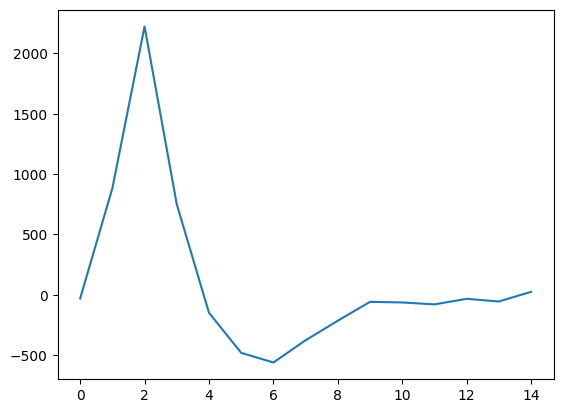

In [6]:
# Get Red channel spatial map, and peak pixel
cell_id = pp.response_block.cell_ids[cell_idx]

sm = pp.analysis_chunk.d_spatial_maps[cell_id][:,:,0]
peak = np.unravel_index(np.argmax(sm), sm.shape)

plt.plot(sta[:,peak[0], peak[1]])

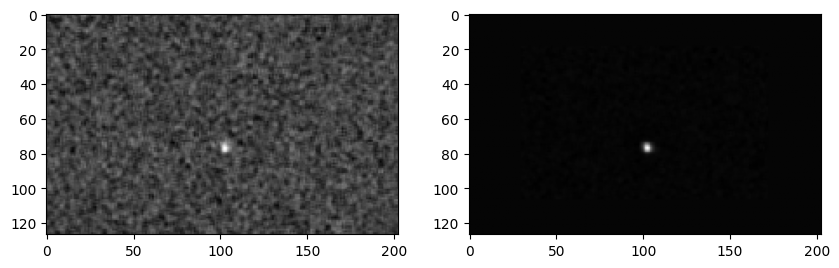

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(sta[3,:,:], cmap='gray')
plt.subplot(122)
plt.imshow(sm, cmap='gray')